In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
import healpy

import lsst.sims.maf.plots as plots
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as mb

from lsst.sims.utils import Site
from lsst.sims.utils import calcLmstLast

In [2]:
lsstSite = Site('LSST')

In [3]:
class Telescope:
    """This class provides a kinematic model of the telescope

    The functionality provided is currently (June 18 2017) limited to
    calculating slew times. Putting the code into a class allows a
    simulator to consider many `Telescope`s at once, each with
    different parameters.

    Attributes
    ----------
    latitude : float
        The latitude of the telescope in radians. This attribute should not
        be changed on Telescope instances, since lsst.sims.speedObservatory.sky
        assumes the default value.
    longitude : float
        The longitude of the telescope in radians. This attribute should not
        be changed on Telescope instances, since lsst.sims.speedObservatory.sky
    filters : list of str
        The filters available on this telescope. This attribute should not
        be modified on instances.
    filterId : dict (keys are str, values are int)
        An integer ID assigned to each filter. This attribute should not
        be modified on instances.
    fovWidth : float
        The width of the field of view in radians.
    domSlitDiam : float
        The width of the dome slit in radians. TODO this assumes a circular
        dome slit, but I think it may actually be rectangular.
    raftWidth : float
        The width of a single raft in radians.
    minRotation : float
        The minimum angle of the rotator in radians.
    maxRotation : float
        The maximum angle of the rotator in radians.
    minAlt : float
        The minimum altitude that the telescope can point at in radians.
    maxAlt : float
        The maximum altitude that the telescope can point at in radians.
    domAltMaxSpeed : float
        The maximum rate of change in dome altitude in radians/s.
    domAltAccel : float
        The maximum acceleration in dome altitude in radians/s/s.
    domAltDecel : float
        The maximum deceleration in dome altitude in radians/s/s.
    domAzMaxSpeed : float
        The maximum rate of change in dome azimuth in radians/s.
    domAzAccel : float
        The maximum acceleration in dome azimuth in radians/s/s.
    domAzDecel : float
        The maximum deceleration in dome azimuth in radians/s/s.
    telAltMaxSpeed : float
        The maximum rate of change in telescope altitude in radians/s.
    telAltAccel : float
        The maximum acceleration in telescope altitude in radians/s/s.
    telAltDecel : float
        The maximum deceleration in telescope altitude in radians/s/s.
    telAzMaxSpeed : float
        The maximum rate of change in telescope azimuth in radians/s.
    telAzAccel : float
        The maximum acceleration in telescope azimuth in radians/s/s.
    telAzDecel : float
        The maximum deceleration in telescope azimuth in radians/s/s.
    rotMaxSpeed : float
        The maximum rate of change in rotator in radians/s.
    rotAccel : float
        The maximum acceleration of the rotator in radians/s/s.
    rotDecel : float
        The maximum deceleration of the rotator in radians/s/s.
    settleTime : float
        The number of seconds it takes for the instrument to settle.
    readoutTime : float
        The number of seconds it takes to read out an exposure from the camera.
    filterChangeTime : float
        The number of seconds it takes to change filters.
    """
    # non-configurable (AstronomicalSky uses these and I don't
    # want to slow it down by requiring it create a Telescope object)
    # (don't modify these on an instance)
    latitude = np.radians(-(30 + 14 / 60 + 40.7 / 3600))
    longitude = np.radians(-(70 + 44 / 60 + 57.9 / 3600))
    filters = ["u", "g", "r", "i", "z", "y"]
    filterId = {}
    for i, filter in enumerate(filters):
        filterId[filter] = i

    def __init__(self):
        self.fovWidth = np.radians(3.5)
        self.domSlitDiam = 2 * self.fovWidth
        self.raftWidth = self.fovWidth / 5
        self.minRotation = -np.pi/2
        self.maxRotation = np.pi/2

        # values from http://ops2.lsst.org/docs/current/system.html
        self.minAlt = np.radians(20.0)
        self.maxAlt = np.radians(86.5)

        # Kinematic and delay parameters for slew time computation

        # speed in rads/sec
        # acceleration in rads/second**2
        self.domAltMaxSpeed = np.radians(1.75)
        self.domAltAccel = np.radians(0.875)
        self.domAltDecel = np.radians(0.875)

        self.domAzMaxSpeed = np.radians(1.5)
        self.domAzAccel = np.radians(0.75)
        self.domAzDecel = np.radians(0.75)

        self.telAltMaxSpeed = np.radians(3.5)
        self.telAltAccel = np.radians(3.5)
        self.telAltDecel = np.radians(3.5)
        # assume accel == decel for calculations below
        # (easy to change but they are the same anyway and I'm  lazy)
        assert(self.telAltAccel == self.telAltDecel)

        self.telAzMaxSpeed = np.radians(7.0)
        self.telAzAccel = np.radians(7.0)
        self.telAzDecel = np.radians(7.0)
        assert(self.telAzAccel == self.telAzDecel)

        # not used in slew calculation
        self.rotMaxSpeed = np.radians(3.5)
        self.rotAccel = np.radians(1.0)
        self.rotDecel = np.radians(1.0)

        self.settleTime = 3
        self.readoutTime = 2
        self.filterChangeTime = 120
        
    def _uamSlewTime(self, d, vmax, a):
        dm = vmax**2 / a
        slewTime = np.where(d < dm, 2 * np.sqrt(d/a), 2 * vmax / a + (d - dm) / vmax)
        return slewTime
        """
        # if you accelerate uniformely to telAltMaxSpeed
        # and then slow down uniformely to zero, you'll travel
        # a distance v_max^2 / a
        if d < vmax**2 / a:
            # to travel a distance d/2 while accelerating at a rate a,
            # it takes time sqrt(2(d/2)/a)
            slewTime = 2 * np.sqrt(d / a)
        else:
            # the time to accelerate/decelerate to/from v_max is 2v_max / a
            # and the distance covered in those two steps is v_max^2 / a
            # so the total time is the accel/decel time plus the remaining
            # distance over v_max
            slewTime = 2 * vmax / a + (d - vmax**2 / a) / vmax
        return slewTime
        """

    def calcSlewTime(self, alt1, az1, filter1, alt2, az2, filter2, laxDome=False):
        """Calculates ``slew'' time

        Calculates the ``slew'' time necessary to get from alt1/az1/filter1
        to alt2/az2/filter2. The time returned is actually the time between
        the end of an exposure at alt1/az1 and the beginning of an exposure
        at alt2/az2, since it includes readout time in the ``slew'' time.

        Parameters
        ----------
        alt1 : float
            The altitude of the initial pointing.
        az1 : float
            The azimuth of the initial pointing.
        filter1 : str
            The filter used in the initial observation.
        alt2 : np.ndarray
            The altitude of the destination pointing.
        az2 : np.ndarray
            The azimuth of the destination pointing.
        filter2 : np.ndarray
            The filter to be used in the destination observation.
        laxDome : boolean
            If True, allow the dome to creep, model a dome slit, and don't
            require the dome to settle in azimuth. If False, adhere to the way
            SOCS calculates slew times (as of June 21 2017).

        Returns
        -------
        np.ndarray
            The number of seconds between the two specified exposures.

        Notes
        -----
        This method should really be called `calcInterExposureTime`, but to be
        consistent with other code/documentation, I've called it `calcSlewTime`.
        """

        # FYI this takes on the order of 10us for 1 slew calculation
        # or now vectorized .. 285 us to calculate slew times to 2293 (.12us per pointing)
    
        # TODO also assumes we never max out the cable wrap-around constraint
        deltaAlt = np.abs(alt2 - alt1)
        deltaAz  = np.abs(az2 - az1)

        deltaAz = np.minimum(deltaAz, np.abs(deltaAz - 2*np.pi))

        telAltSlewTime = self._uamSlewTime(deltaAlt, self.telAltMaxSpeed, self.telAltAccel)
        telAzSlewTime  = self._uamSlewTime(deltaAz,  self.telAzMaxSpeed,  self.telAzAccel)
        totTelTime = np.maximum(telAltSlewTime, telAzSlewTime)

        # open loop optics correction
        olTime = deltaAlt / np.radians(3.5)
        totTelTime += olTime

        settleAndOL = np.where(totTelTime > 0)
        totTelTime[settleAndOL] += np.maximum(0, self.settleTime - olTime[settleAndOL])        
        # readout puts a floor on tel time
        totTelTime = np.maximum(self.readoutTime, totTelTime)

        # now compute dome slew time
        if laxDome:
            totDomeTime = np.zeros(len(alt2), float)
            # model dome creep, dome slit, and no azimuth settle
            # if we can fit both exposures in the dome slit, do so
            sameDome = np.where(deltaAlt**2 + deltaAz**2 < self.fovWidth**2)

            # else, we take the minimum time from two options:
            # 1. assume we line up alt in the center of the dome slit so we
            #    minimize distance we have to travel in azimuth.
            # 2. line up az in the center of the slit
            # also assume:
            # * that we start out going maxspeed for both alt and az
            # * that we only just barely have to get the new field in the
            #   dome slit in one direction, but that we have to center the
            #   field in the other (which depends which of the two options used)
            # * that we don't have to slow down until after the shutter
            #   starts opening
            domDeltaAlt = deltaAlt
            # on each side, we can start out with the dome shifted away from
            # the center of the field by an amount domSlitRadius - fovRadius
            domDeltaAz = deltaAz - 2 * (self.domSlitDiam/2 - self.fovWidth/2)
            domAltSlewTime = domDeltaAlt / self.domAltMaxSpeed
            domAzSlewTime  = domDeltaAz  / self.domAzMaxSpeed
            totDomTime1 = np.maximum(domAltSlewTime, domAzSlewTime)

            domDeltaAlt = deltaAlt - 2 * (self.domSlitDiam/2 - self.fovWidth/2)
            domDeltaAz  = deltaAz
            domAltSlewTime = domDeltaAlt / self.domAltMaxSpeed
            domAzSlewTime  = domDeltaAz  / self.domAzMaxSpeed
            totDomTime2 = np.maximum(domAltSlewTime, domAzSlewTime)

            totDomTime = np.minimum(totDomTime1, totDomTime2)
            totDomTime[sameDome] = 0

        else:
            # the above models a dome slit and dome creep. However, it appears that
            # SOCS requires the dome to slew exactly to each field and settle in az
            domAltSlewTime = self._uamSlewTime(deltaAlt, self.domAltMaxSpeed, self.domAltAccel)
            domAzSlewTime  = self._uamSlewTime(deltaAz,  self.domAzMaxSpeed,  self.domAzAccel)
            # Dome takes 1 second to settle in az
            domAzSlewTime = np.where(domAzSlewTime > 0, domAzSlewTime + 1.0, domAzSlewTime)
            totDomTime = np.maximum(domAltSlewTime, domAzSlewTime)


        slewTime = np.maximum(totTelTime, totDomTime)

        # include filter change time if necessary
        filterChange = np.where(filter2 != filter1)
        slewTime[filterChange] = np.maximum(slewTime[filterChange], 
                                            self.filterChangeTime)

        # closed loop optics correction
        closeLoop = np.where(deltaAlt >= np.radians(9))
        slewTime[closeLoop] += 20

        return slewTime

/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


1

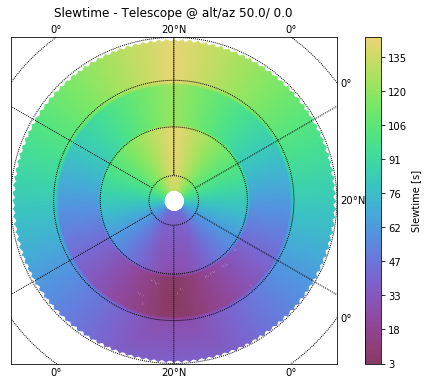

In [69]:
telAlt_deg,telAz_deg = 50.,0.
telAlt,telAz = np.radians(telAlt_deg),np.radians(telAz_deg)
tel = Telescope()
slewtime = tel.calcSlewTime(telAlt, telAz, 'g', alt, az, 'g')
val = ma.MaskedArray(data=slewtime, mask=azmask)
plotDict = {'figsize':(10, 6), 'title': 'Slewtime - Telescope @ alt/az %4.1f/%4.1f' % (telAlt_deg,
                                                                                        telAz_deg), 
            'xlabel': 'Slewtime [s]'}
plots.LambertSkyMap()(val, s, plotDict)

/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


1

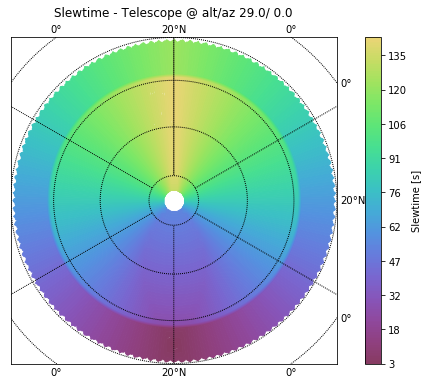

In [68]:
telAlt_deg,telAz_deg = 29.,0.
telAlt,telAz = np.radians(telAlt_deg),np.radians(telAz_deg)
tel = Telescope()
slewtime = tel.calcSlewTime(telAlt, telAz, 'g', alt, az, 'g')
val = ma.MaskedArray(data=slewtime, mask=azmask)
plotDict = {'figsize':(10, 6), 'title': 'Slewtime - Telescope @ alt/az %4.1f/%4.1f' % (telAlt_deg,
                                                                                        telAz_deg), 
            'xlabel': 'Slewtime [s]'}
plots.LambertSkyMap()(val, s, plotDict)

/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


1

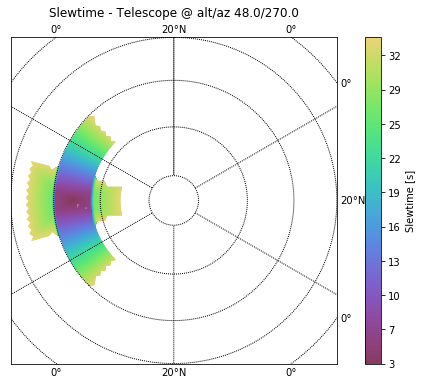

In [73]:
telAlt_deg,telAz_deg = 48.,270.
telAlt,telAz = np.radians(telAlt_deg),np.radians(telAz_deg)
tel = Telescope()
slewtime = tel.calcSlewTime(telAlt, telAz, 'g', alt, az, 'g')
slew_mask = np.where(slewtime > (np.min(slewtime)+30.), True, False)
val = ma.MaskedArray(data=slewtime, mask=slew_mask)
plotDict = {'figsize':(10, 6), 'title': 'Slewtime - Telescope @ alt/az %4.1f/%4.1f' % (telAlt_deg,
                                                                                        telAz_deg), 
            'xlabel': 'Slewtime [s]'}
plots.LambertSkyMap()(val, s, plotDict)

In [45]:
# s = slicers.HealpixSlicer(nside=32)
s = slicers.HealpixSlicer(nside=32,latCol='zenithDistance', lonCol='azimuth')
az = s.slicePoints['ra']
alt = s.slicePoints['dec']
tnow = 59580.0
# alt, az = stackers.raDec2AltAz(ra, dec, lsstSite.latitude_rad, lsstSite.longitude_rad, tnow)
# lmst, last = calcLmstLast(tnow, lsstSite.longitude_rad)
# lmst_deg = lmst / 24.0 * 360.0
# print('LMST', lmst, 'hrs', lmst_deg, 'deg')
azmask = np.where(np.bitwise_or(np.degrees(alt)<20, np.degrees(alt)>86.5), True, False)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [46]:
print(s.slicePoints.keys())

dict_keys(['sid', 'ra', 'dec', 'nside'])


/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


1

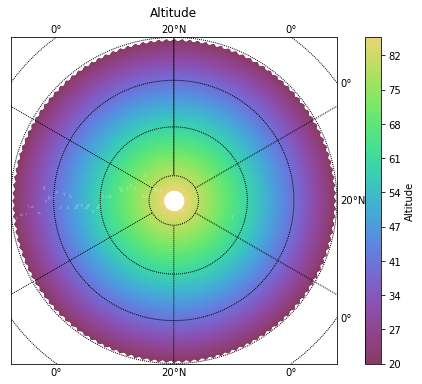

In [47]:
val = ma.MaskedArray(data=np.degrees(alt), mask=azmask)
plotDict = {'figsize':(10, 6), 'title': 'Altitude', 'xlabel': 'Altitude'}
plots.LambertSkyMap()(val, s, plotDict)

/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


1

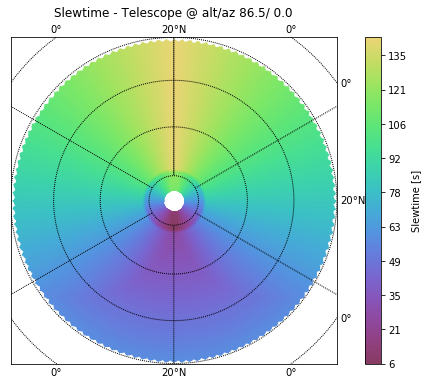

In [70]:
telAlt_deg,telAz_deg = 86.5,0.
telAlt,telAz = np.radians(telAlt_deg),np.radians(telAz_deg)
tel = Telescope()
slewtime = tel.calcSlewTime(telAlt, telAz, 'g', alt, az, 'g')
val = ma.MaskedArray(data=slewtime, mask=azmask)
plotDict = {'figsize':(10, 6), 'title': 'Slewtime - Telescope @ alt/az %4.1f/%4.1f' % (telAlt_deg,
                                                                                        telAz_deg), 
            'xlabel': 'Slewtime [s]'}
plots.LambertSkyMap()(val, s, plotDict)

/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/tribeiro/lsst_stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


1

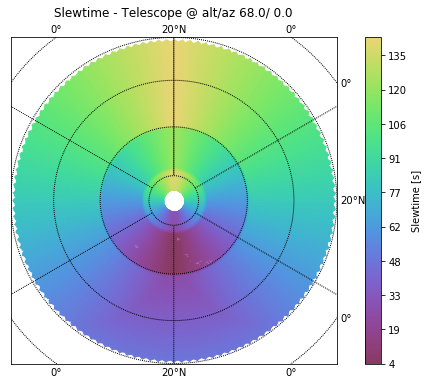

In [71]:
telAlt_deg,telAz_deg = 68.,0.
telAlt,telAz = np.radians(telAlt_deg),np.radians(telAz_deg)
tel = Telescope()
slewtime = tel.calcSlewTime(telAlt, telAz, 'g', alt, az, 'g')
val = ma.MaskedArray(data=slewtime, mask=azmask)
plotDict = {'figsize':(10, 6), 'title': 'Slewtime - Telescope @ alt/az %4.1f/%4.1f' % (telAlt_deg,
                                                                                        telAz_deg), 
            'xlabel': 'Slewtime [s]'}
plots.LambertSkyMap()(val, s, plotDict)

In [6]:
telRA = np.radians(lmst_deg)
telDec = np.radians(10)
telAlt, telAz = stackers.raDec2AltAz(np.array([telRA]), np.array([telDec]),
                                     lsstSite.latitude_rad, lsstSite.longitude_rad, tnow)
telAlt = telAlt[0]
telAz = telAz[0]
print('ra/dec', np.degrees(telRA), np.degrees(telDec), 'alt/az', np.degrees(telAlt), np.degrees(telAz))
tel = Telescope()
slewtime = tel.calcSlewTime(telAlt, telAz, 'g', alt, az, 'g')
print(slewtime.min(), slewtime.max())

('ra/dec', 29.880636051930953, 10.0, 'alt/az', 49.755599999999987, 1.2074182697257333e-06)
(3.6799288833690076, 142.81751116579539)


1

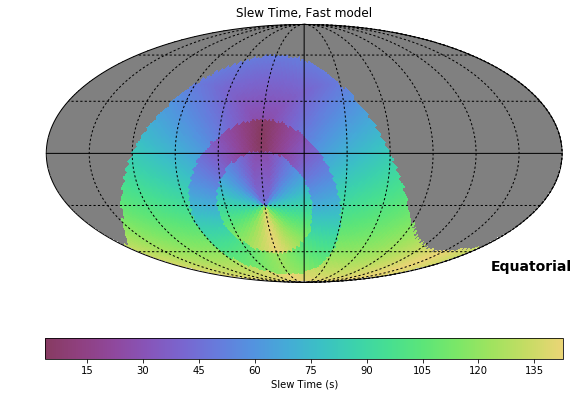

In [7]:
val = ma.MaskedArray(data=slewtime, mask=azmask)
plotDict = {'figsize':(10, 6), 'title': 'Slew Time, Fast model', 'xlabel': 'Slew Time (s)'}
plots.HealpixSkyMap()(val, s, plotDict)

In [8]:
# First get observatory model set up correctly. 
# tnow is in MJD (TAI) and we need to convert to unix timestamp.
from astropy.time import Time
t = Time(tnow, format='mjd', scale='tai')

from lsst.ts.observatory.model import Target
from lsst.ts.observatory.model import ObservatoryModel
from lsst.ts.observatory.model import ObservatoryState
from lsst.ts.observatory.model import ObservatoryPosition

observatoryModel = ObservatoryModel()
observatoryModel.configure_from_module()
observatoryModel.update_state(t.unix)
print(observatoryModel)

t=1640995163.0 ra=29.726 dec=-26.744 ang=180.000 filter=r track=False alt=86.500 az=0.000 pa=180.000 rot=0.000 telaz=0.000 telrot=0.000 mounted=['g', 'r', 'i', 'z', 'y'] unmounted=['u']


In [9]:
# Set new observatory position/state.
startTarget = Target(band_filter='g', ra_rad=telRA, dec_rad=telDec, num_exp=1, exp_times=[15.0, 15.0])
observatoryModel.slew(startTarget)
observatoryModel.update_state(t.unix)
print(observatoryModel)

t=1640995303.0 ra=29.881 dec=10.000 ang=180.207 filter=g track=True alt=49.753 az=359.344 pa=179.425 rot=359.218 telaz=-0.656 telrot=-0.782 mounted=['g', 'r', 'i', 'z', 'y'] unmounted=['u']


In [10]:
slewT = np.zeros(len(ra), float)
for i in range(len(slewT)):
    target = Target(band_filter='g', ra_rad=ra[i], dec_rad=dec[i], num_exp=2, exp_times=[15.0, 15.0])
    slewT[i] = observatoryModel.get_slew_delay(target)
slewT.min(), slewT.max()

(-1.0, 142.93040144600235)

1

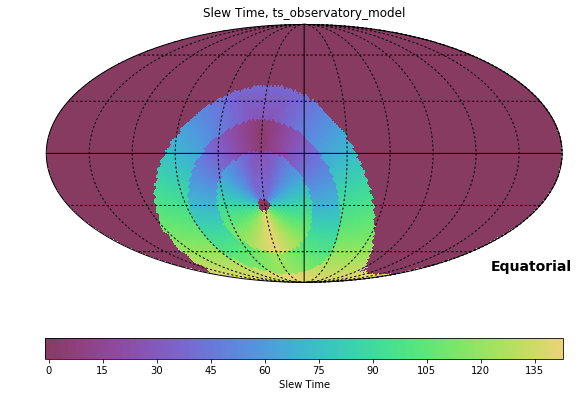

In [11]:
val = ma.MaskedArray(data=slewT, mask=False)
plotDict = {'figsize':(10, 6), 'title': 'Slew Time, ts_observatory_model', 'xlabel': 'Slew Time'}
plots.HealpixSkyMap()(val, s, plotDict)

('Min and max differences between Fast - ts_observatory_model', -20.185053701615168, 143.81751116579539)


1

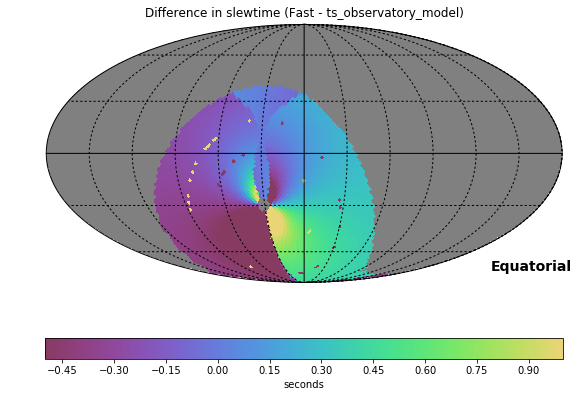

In [12]:
newmask = np.where(slewT<=0, True, False)
diff = slewtime - slewT
print('Min and max differences between Fast - ts_observatory_model', diff.min(), diff.max())
val = ma.MaskedArray(data=diff, mask=newmask)
plotDict = {'figsize':(10, 6), 'title': 'Difference in slewtime (Fast - ts_observatory_model)', 
            'xlabel': 'seconds',
            'colorMin':-.5, 'colorMax':1}
plots.HealpixSkyMap()(val, s, plotDict)

In [13]:
# Now do it using SOCS
import copy
from lsst.sims.ocs.observatory import MainObservatory
from lsst.sims.ocs.configuration import ObservingSite, Observatory
mo = MainObservatory(ObservingSite())
mo.configure(Observatory())
model = mo.model

def opsimSlewTime(model, alt1=None, alt2=None, az1=None, az2=None, rot1=None, rot2=None):
    # park the observatory, then go from alt1,az1 to alt2,az2
    if alt1 is None:
        alt1 = model.current_state.alt
    if alt2 is None:
        alt2 = model.current_state.alt
    if az1 is None:
        az1 = model.current_state.az
    if az2 is None:
        az2 = model.current_state.az
    if rot1 is None:
        rot1 = model.current_state.rot
    if rot2 is None:
        rot2 = model.current_state.rot

    model.park()
    model.slew_altaz(0., np.radians(alt1), np.radians(az1), np.radians(rot1), model.current_state.filter)
    initial_slew_state = copy.deepcopy(model.current_state)

    model.slew_altaz(model.current_state.time, np.radians(alt2), np.radians(az2), np.radians(rot2),
                     model.current_state.filter)

    final_slew_state = copy.deepcopy(model.current_state)
    slew_time = final_slew_state.time - initial_slew_state.time

    return slew_time

In [14]:
slewT2 = np.zeros(len(ra), float)
for i in range(len(slewT2)):
    slewT2[i] = opsimSlewTime(model, alt1=np.degrees(telAlt), az1=np.degrees(telAz),
                              alt2=np.degrees(alt[i]), az2=np.degrees(az[i]), rot1=None, rot2=None)
slewT2.min(), slewT2.max()

(3.6799288833281025, 142.81751116574742)

1

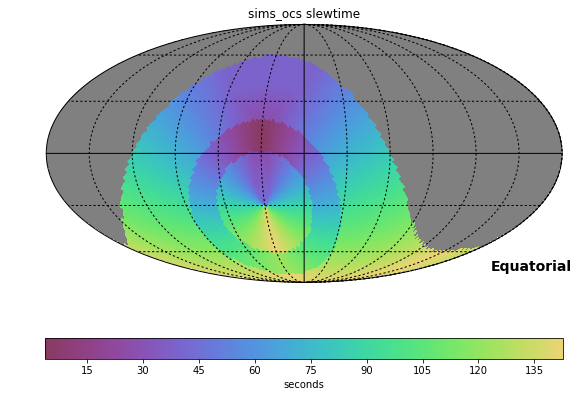

In [15]:
val = ma.MaskedArray(data=slewT2, mask=azmask)
plotDict = {'figsize':(10, 6), 'title': 'sims_ocs slewtime', 'xlabel': 'seconds'}
plots.HealpixSkyMap()(val, s, plotDict)

('Min and max differences between SOCS-ts_observatory_model', -20.185053701635155, 143.81751116574742)


1

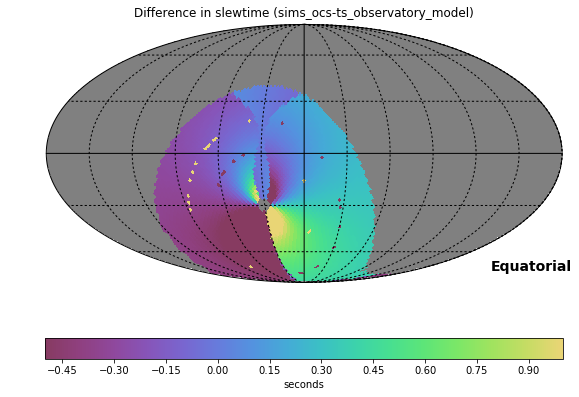

In [16]:
diff = slewT2 - slewT
print('Min and max differences between SOCS-ts_observatory_model', diff.min(), diff.max())
val = ma.MaskedArray(data=diff, mask=newmask)
plotDict = {'figsize':(10, 6), 'title': 'Difference in slewtime (sims_ocs-ts_observatory_model)',
            'xlabel': 'seconds', 'colorMin':-.5, 'colorMax':1}
plots.HealpixSkyMap()(val, s, plotDict)

('Min and max differences between SOCS - Fast', -61.388526965070511, 2.326032699784264e-10)


1

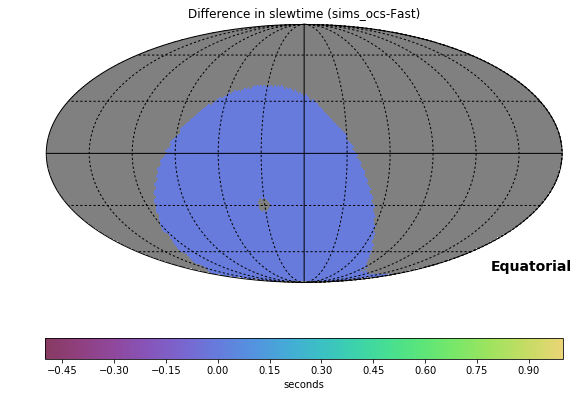

In [17]:
diff = slewT2 - slewtime
print('Min and max differences between SOCS - Fast', diff.min(), diff.max())
val = ma.MaskedArray(data=diff, mask=newmask)
plotDict = {'figsize':(10, 6), 'title': 'Difference in slewtime (sims_ocs-Fast)',
            'xlabel': 'seconds', 'colorMin':-.5, 'colorMax':1}
plots.HealpixSkyMap()(val, s, plotDict)

Maybe the difference is due to the "History" of the telescope? But in both, sims_ocs and ts_observatory, we're moving from zenith/park to telAlt/Az and then on to alt/az of the pointing. So the cable wrap effects should be the same. 